# Lab 7: Unsupervised Learning - part II
Machine Learning 2021/2022 <br>
Ruben Wiersma and Gosia Migut

Revised by Lisette Veldkamp

**WHAT** This nonmandatory lab consists of several programming exercises and insight questions on unsupervised learning with k-means clustering and PCA. 

**WHY** The exercises are meant to familiarize yourself with the basic concepts of unsupervised learning.

**HOW** Follow the exercises in this notebook either on your own or with a friend. There is quite a bit of theory and explanation in these notebooks. If you want to skip right to questions and exercises, find the $\rightarrow$ symbol. For questions and feedback please consult the TAs during the lab session. 

$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$

## Learning without examples continued

As a child you probably taught yourself how to separate building blocks from each other. Even without someone telling you which shape was which, you were able to decide which shapes belonged with each other and make separate heaps of cubes, cylinders, and pyramids. You performed a type of unsupervised learning: *clustering*.

### Structure

The assignment about unsupervised learning consists of two parts (each is presented in a different jupyter notebook):
- In [Part 1](part1_dimensionalityreduction.ipynb), you have become familiar with dimensionality reduction using Principal Component Analysis (PCA). 
- In **this** part, [Part 2](part2_clustering.ipynb), you will apply the implemented PCA algorithm and perform k-means clustering on the retrieved features.

    Part 2 consists of the following two steps:

   1. Preparing the data: extract and reduce features from the data.
   2. K-means clustering: implement k-means clustering to apply it on the retrieved features.

## 1. Preparing the data

In this assignment, you will work with the *TIDIGITS* dataset. This dataset was created by Texas Instruments (hence, TI) and is a set of voice recordings of digits. You can go ahead and give the audio files a listen in the data folder: `data/tidigits/...`.

Before we can use any clustering algorithms on this data, we need a way to describe our audio files in a way that a computer can understand. An audio file is read as an array, where each value in the array is the amplitude of the audio at a the corresponding time. We refer to this data as _raw_ waveforms. It's infeasible to use the raw data for clustering. We need to extract a limited number of features to describe each audiofile: we perform __feature extraction__.

We will extract _MFCC_ features, which are often used for speech processing. To extract these, we split the audio file in frames of 25 ms each. Next, we apply a number of complicated operations to retrieve 13 features per frame. If a file is split into, for example, 100 frames, this means we have $13 * 100 = 1300$ features! To bring this number down, we sample  5  frames from regular intervals (the size of the interval is dependent on the length of the audio file) and flatten this to an array of  $5 ∗ 13 = 65$  features (this number is thus independent of the length of the audio file).

$\ex{1.1}$ Run the code below to extract MFCC features for the 150 files provided. This will give you a dataset with 50 'one' audiofiles, 50 'two' audiofiles and 50 'three' audiofiles.

Before doing this, you need to have `python_speech_features` and `soundfile` installed. These can be installed with the command:
```
pip install python_speech_features SoundFile
```

If this fails, you can use the backup dataset that is provided down below.

In [1]:
import numpy as np
import numpy.linalg as la
import python_speech_features as features
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def extract_mfcc(sound, sample = 5):
    # Read in the flac file
    data, samplerate = sf.read(sound)
    
    # Extract MFCC features.
    # For each frame (25ms segment of audio) in the file, we get 13 MFCC features,
    # giving us a [n x 5] matrix of features
    mfcc_feat = np.asarray(features.mfcc(data,samplerate), dtype='float32')
    
    # We sample 5 frames and flatten the feature vectors into one large 'supervector'.
    idx = np.floor(np.linspace(0, mfcc_feat.shape[0] - 1, sample)).astype(int)
    mfcc_sampled = mfcc_feat[idx]
    mfcc_feat_vector = mfcc_sampled.flatten()
    
    return mfcc_feat_vector

# Read audiofiles and extract MFCC feature vectors
one = []
for i in range(50):
    feat = extract_mfcc("data/tidigits/1/{:d}.flac".format(i))
    one.append(feat)
two = []
for i in range(50):
    feat = extract_mfcc("data/tidigits/2/{:d}.flac".format(i))
    two.append(feat)
three = []
for i in range(50):
    feat = extract_mfcc("data/tidigits/3/{:d}.flac".format(i))
    three.append(feat)

# Concatenate into one large dataset
X_train = np.concatenate((one, two, three))
ones = np.ones(50)
y_train = np.concatenate((ones, ones * 2, ones * 3)).astype(int)
np.savetxt("data/tidigits_features.txt", X_train)
np.savetxt("data/tidigits_targets.txt", y_train)

In [2]:
# Backup if you cannot load the MFCC code, in that case uncomment the lines below
# X_train = np.loadtxt("data/tidigits_features.txt")
# y_train = np.loadtxt("data/tidigits_targets.txt")

### Reducing the number of features

Now we have 150 data points (i.e. 150 audio files) and each data point consists of 65 features describing the audio file. Let's plot the the first two features.

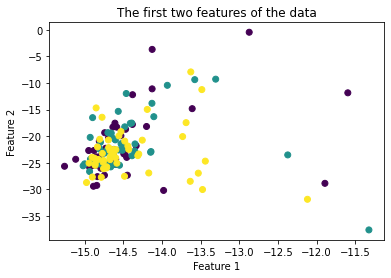

In [3]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title('The first two features of the data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Well, it seems like we can't cluster our points based on the first two features. There is however some combination of features that will allow us to cluster the data points. If only there was a way to automatically find this combination without supervision...

But wait! We do have such a technique: PCA. And you have just implemented it in the previous part. Let's go ahead and apply PCA to find the four most descriptive 'directions' in the data and project the features onto these directions.

This involves the following steps:
1. compute the covariance matrix of the dataset;
2. compute the first four eigenvectors (i.e. principal components) of the covariance matrix;
3. reorient the data points from the original axes to the ones represented by these principal components (this is done using the dot product).
   
This should give us four features for each point that describe the audio well. We are plotting just two of these features, as this can be easily visualised, but we will need four features to accurately cluster all points.

$\ex{1.2}$ Complete the following code to reduce the number of features with PCA. Plot your results.

__Hint__ You can use your own implementation of PCA, or use PCA from Scipy's or Numpy's linear algebra library. Note that the numpy version is a bit more precise which can explain (small) differences between the results.

(65, 65) (150, 65)


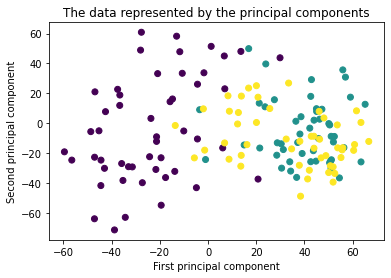

In [4]:
# First compute the covariance matrix of the dataset

# START ANSWER
residual = X_train - X_train.mean(axis=0, keepdims=True)
cov_matrix = residual.T @ residual
print(cov_matrix.shape, X_train.shape)
# END ANSWER

# Next, retrieve four eigenvectors of the covariance matrix
# CHALLENGE: you can use your own implementation of power iteration from part I of the lab to find the eigenvectors.

# START ANSWER
eigenvectors = []
for i in range(4):
    v_old = np.ones(len(cov_matrix))
    while True:
        v_new = cov_matrix @ v_old / la.norm(cov_matrix @ v_old)
        if la.norm(v_new - v_old) < 1e-5:
            eigenvectors.append(v_new)
            eigen_value = v_new.T @ cov_matrix @ v_new
            cov_matrix = cov_matrix - eigen_value * v_new.reshape(-1, 1) * v_new.reshape(1, -1)
            break
        v_old = v_new
        
eigenvectors = np.stack(eigenvectors)
# END ANSWER

# Finally, we project our points onto the eigenvectors (principal components) using matrix multiplication
X_train_reduced = np.zeros((X_train.shape[0], 4))
for i in range(len(X_train)):
    X_train_reduced[i, :] = np.matmul(X_train[i, :].T, eigenvectors.T).T
        
# And plot the points with the new data
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train)
plt.title('The data represented by the principal components')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

Looks like we have ourselves a dataset that we can start clustering!

__Important note:__ We have now shown the labels for each point as the colour, but we will not be using labels for training. You will only use the labels to verify the clusters you are deriving from the data itself.

# 2. K-means clustering

We will now implement the (original) k-means clustering algorithm. This algorithm works as follows: we start with $k$ clusters and pick some random centre (mean) for each cluster. Next, we assign points to each cluster based on the distance to the centres and we update the centre to be the mean of all points in that cluster. This is repeated until the centres have converged.

Pointwise, the steps of the k-means clustering algorithm approach are as follows:
1. initialize $k$ cluster centers at random locations;
2. assign each point to a cluster;
3. update the cluster centers;
4. go to step 2 unless converged or a certain number of iterations has been reached.

First, we will create a `Cluster` class.

$\ex{1.1}$ Finish the method that calculates the centroid (other word for centre) of the cluster,
`Cluster.centroid`. The centroid is the mean vector of all feature vectors. This method is called frequently, while the cluster (and naturally the centroid) does not always change. To increase efficiency, store and reuse the cluster centroid until the cluster itself changes (i.e. points are added or removed), at which point a new centroid should be calculated.

__Hint:__ You can use the ``changed`` flag to see if the centroid needs to be recomputed or if the current value is still valid.

In [5]:
import numpy as np

# This object is used to store the clusters. A Cluster object consists of a numpy matrix
# containing all feature vectors in the cluster and the centroid of all the vectors.
# The object also contains a boolean for speedup purposes.
class Cluster(object):

    def __init__(self, data=None):
        self.changed = True
        if data is not None:
            self.data = np.array(data)
        else:
            self.data = None
            self.reset_cluster()
            
        self.cd = None
        
    def reset_cluster(self):
        self.data = np.array([[]])
    
    def is_changed(self):
        return self.changed
    
    def set_changed(self, changed):
        self.changed = changed
    
    def set_centroid(self, vector):
        self.cd = vector
    
    def append(self, other):
        # Set changed flag to true (the cluster has changed)
        self.set_changed(True)
        self.data = np.concatenate([self.data, np.array([other])])

    def centroid(self):
        if self.changed:
            self.set_centroid(np.mean(self.data, axis=0))
            self.changed = False
        return self.cd
    
# Test case for the Cluster class
c = Cluster(np.array([[0, 1], [2, 0]]))

# Verifies that the centroid is calculated correctly
np.testing.assert_array_equal(c.centroid(), np.array([1.0, 0.5]))

# Verifies that the centroid is calculated correctly after a new data point has been added.
c.append(np.array([1, 2]))
np.testing.assert_array_equal(c.centroid(), np.array([1.0, 1.0]))

Next, let's take a look at the data that we will be clustering. We plotted the data here as the algorithm will see it, thus without labels.

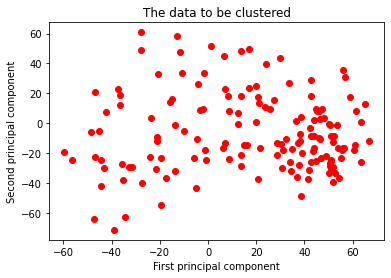

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# This function is only used when the previous steps for feature extraction and reduction have failed.
# It can be used to load the given cluster data into a list of cluster objects.
def read_file(file):
    lines = [line.rstrip('\n') for line in open(file)]
    # Initialise data structure
    points = []
    for line in lines:
        # Take FeatureVector from dataset
        elements = line.split(" ")
        p = [float(el) for el in elements]
        # Append FeatureVector to the list of clusters
        points.append(p)
    points = np.asarray(points)
    return points

# If the previous steps for feature extraction and reduction failed, you can use this data.
# Otherwise, use the data and features you extracted yourself!
# points = read_file("data/cluster.txt")

points = X_train_reduced
x = points[:, 0]
y = points[:, 1]
plt.scatter(x, y, c='r')
plt.title('The data to be clustered')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

### Step 1

Now you will start implementing k-means. Let's start at step 1: *initialize $k$ cluster centers at random locations*.

$\ex{1.2}$  Finish the `addInitPoints` function. This function selects a random point in the dataset, constructs a cluster from it and adds the cluster to the list of clusters.  
**Hint:** We imported the `sample()` method, you can use it to create a list of elements drawn at random.

In [7]:
from random import sample

# This function selects random k points from the dataset. For each random point it initializes a cluster 
# and adds the cluster to the list of clusters.
def add_init_points(points, clusters, k):
    # START ANSWER
    indices = sample(list(range(len(points))), k)
    for point_index in sample(indices, k):
        cluster = Cluster(points)
        cluster.set_centroid(points[point_index])
        clusters.append(cluster)
    # END ANSWER
    return clusters

# Verifies that a cluster has been added as a init point
init_points = add_init_points(np.array([[0, 0], [0, 0]]), [], 1)
assert len(init_points) == 1
np.testing.assert_array_equal(init_points[0].centroid(), np.array([0.0, 0.0]))

### Step 2
In the update process, we assign points to clusters based on their distance to each centroid. This is step 2 of k-means: *assign each point to a cluster*.

$\ex{1.3}$ Implement the `distance` function. We will use Euclidean distance.

In [8]:
def distance(p1, p2):
    # Euclidian distance between 2 points (in any space)
    return np.sum((p1 - p2) ** 2) ** .5
    # START ANSWER
    # END ANSWER

# Verifies that the distance metric is correct
np.testing.assert_array_equal(distance(np.zeros([1, 2]), np.ones([1, 2])), np.sqrt(2))

### Step 3
$\ex{1.4}$ Now implement the update step (3.) of the k-means clustering algorithm. First, use `addInitPoint` if no clusters are present yet to initialize $k$ clusters. After this check, we perform an iteration of the k-means clustering algorithm. This consists of the following steps: 
1. calculate the centroids of each cluster and save them;
2. remove all points from all clusters;
3. add each point to the closest cluster centroid (the centroids that you saved earlier).

You will want to save the cluster centroids as they will change during the last step when they are recalculated.

In [9]:
import sys

# This function updates the list of k clusters
def update_k_means(points, clusters, k):
    # Reset clusters   
    centroids = []
 
    # Add initial points
    # If add_clusters is true, initialise clusters with add_init_points
    # Then add the cluster centroids to the centroids list
    add_clusters = len(clusters) != k
    # START ANSWER    
    if add_clusters:
        clusters = add_init_points(points, clusters, k)
        centroids = [cluster.cd for cluster in clusters]
        
    else:
        centroids = [cluster.centroid() for cluster in clusters]
    # END ANSWER

    # Reset clusters from last iteration,
    # so the clustering can be performed with new centroids
    for cluster in clusters:
        cluster.reset_cluster()
        
    clusters = [None for el in range(k)]
    for p in points:
        # Calculate the min distance to one of the centroids
        # START ANSWER
        distances = [distance(p, centroid) for centroid in centroids]
        label = distances.index(min(distances))
        # END ANSWER  
    
        # Add the data point to the cluster with min_distance to centroid
        if label >= 0:
            if clusters[label] is None:
                clusters[label] = Cluster([p])
            else:
                clusters[label].append(p)
         
    return clusters

### Step 4
$\ex{1.5a}$ Use the `plot_k_means_data` function to plot the clustered data and have it analyse the *TIDIGITS* dataset (or `data/cluster.txt` if this is not possible) with $k$ set to 3. Run the k-means clustering algorithm and verify that it is clustering the points as intended. Use `plot_k_means_data_update` to see the cluster updates at each iteration. Note that you may need to run your algorithm with a different random seed to get a proper clustering.

__Hint:__ Updating the clusters is a stateful operation, so if you want to keep the previous cluster you should make a deep copy of it using `copy.deepcopy`.

In [10]:
import matplotlib.cm as cm
    
def plot_k_means_data( clusters, k, itr):
    colors = cm.brg(np.linspace(0,1,k))
    for (i,cl) in enumerate(colors):
        x = [[el[0]] for el in clusters[i].data]
        y = [[el[1]] for el in clusters[i].data] 
        plt.scatter(x, y, c=[cl])
        plt.scatter(clusters[i].centroid()[0], clusters[i].centroid()[1], c='black')
        plt.title("Clusters at update " + str(itr))
    plt.show()
    
def plot_k_means_data_update(clusters_prev, clusters, k):
    if(clusters_prev == []):
        return
    colors = cm.brg(np.linspace(0,1,k))
    for (i,cl) in enumerate(colors):
        
        x = [[el[0]] for el in clusters[i].data]
        y = [[el[1]] for el in clusters[i].data] 
        plt.scatter(x, y, c=[cl], marker = '*')

        plt.scatter(clusters[i].centroid()[0], clusters[i].centroid()[1], c='black')
        
        x_prev = [[el[0]] for el in clusters_prev[i].data]
        y_prev = [[el[1]] for el in clusters_prev[i].data]
        
        plt.scatter(x_prev, y_prev, c=[cl], alpha=0.2, s=100)
        
        plt.scatter(clusters_prev[i].centroid()[0], clusters_prev[i].centroid()[1], c='green')
        plt.legend(['New clusters', 'New centroids', 'Previous clusters', 'Previous centroids'], 
                   loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Difference between updates')
    plt.show()

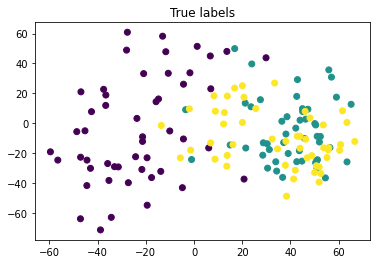

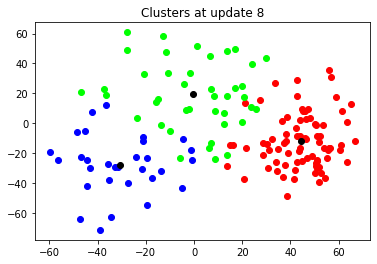

In [17]:
import copy
import random

random.seed(42)
points = X_train_reduced # Ex 1.5a
# points = X_train # Ex 1.5b (optional)
clusters = []
clusters_prev = []
centroids = []
k = 3

# Run here the update_k_means function with k=3 using the clusters list. 
# Keep updating until there is no change in centroids in consecutive iterations 
# or a maximum number of iterations (e.g. 10) is reached.

# START ANSWER
for i in range(10):
    clusters = update_k_means(points, clusters, k)
    centroids = np.stack([cluster.centroid() for cluster in clusters])
    if (centroids == centroids_prev).all():
        break
    centroids_prev = centroids
# END ANSWER
        
# Ground truth
plt.scatter(points[:, 0], points[:, 1], c=y_train)
plt.title('True labels')
plt.show()

plot_k_means_data(clusters, k, i)

$\ex{1.5b}$ (Optional) Try using the clustering on the raw audiofiles (uncomment the `points = X_train` line). How does this approach compare to the PCA-extracted features?

$\q{1.1}$ Compare the clusters that were computed using k-means with the actual labels.

### Step 5

Now that we have a cluster, we would like to find out how good our clustering is. We will also do this using an unsupervised approach: without knowing the correct labels for each cluster, we _can_ say something about the spread of each cluster.

For this purpose you will compute the _sum of residual squares_ (SRS) of the cluster. This is computed as follows: sum over the squared euclidean distances between each point and their corresponding centroid and divide by the total number of points. In math notation:

$$
    srs = \frac{1}{N} \sum_{i \in C} (p_i - c)^2
$$

with $N$ the number of points, $C$ the cluster containing point $i$ and centroid $c$, and $p_i$ the feature vector for point $i$.

$\ex{1.6}$ Implement the `calculate_average_sum_rs` function, which computes the average sum of residual squares.

In [18]:
# This function calculates the average sum of residual squares of the given cluster
def calculate_average_sum_rs(cluster):
    if cluster.data.size == 0:
        return None
    # START ANSWER
    return np.mean((cluster.data - cluster.centroid()) ** 2)
    # END ANSWER

### Step 6

Next, we will use this metric to try and automatically determine how many clusters we should use.

$\ex{1.7}$ Implement the `tune_k` method. This method should test out several values for $k$ in range from 1 to 15. Then, for each $k$, run the k-means algorithm on `data/cluster.txt` with $10$ update iterations. After the algorithm is done, calculate the average SRS of all clusters and print them.

Picking k = 1 gives srs = 677.9553945617539
Picking k = 2 gives srs = 477.3959066235537
Picking k = 3 gives srs = 372.94687432346467
Picking k = 4 gives srs = 266.24739241916905
Picking k = 5 gives srs = 260.28754228265115
Picking k = 6 gives srs = 208.09717161004878
Picking k = 7 gives srs = 189.36392517843595
Picking k = 8 gives srs = 170.54625281408804
Picking k = 9 gives srs = 162.20921637114668
Picking k = 10 gives srs = 142.5175928522345
Picking k = 11 gives srs = 139.7443105673042
Picking k = 12 gives srs = 137.3605000225813
Picking k = 13 gives srs = 127.44365949437211
Picking k = 14 gives srs = 115.97273017221474
Picking k = 15 gives srs = 111.65706790861726


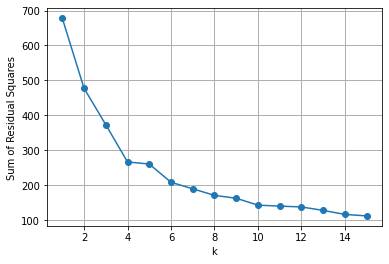

In [23]:
random.seed(42)

# This function tries a number of k's for the update_k_means function (which is our kMean classifier)
# and calculates the SRS for each k. 
# For each k, n_updates iterations of the update_k_means function are performed.
def tune_k(min_k, max_k, n_updates):
    assert 0 < min_k < max_k
    assert n_updates > 1
    srss = []
    
    # START ANSWER
    for k in range(min_k, max_k + 1):
        centroids_prev = np.stack([np.zeros((points.shape[1])) for x in range(k)])
        clusters = []
        for i in range(10):
            clusters = update_k_means(points, clusters, k)
            centroids = np.stack([cluster.centroid() for cluster in clusters])
            if (centroids == centroids_prev).all():
                break
            centroids_prev = centroids
        srss.append(sum([calculate_average_sum_rs(cluster) for cluster in clusters]) / k)
        print(f"Picking k = {k} gives srs = {srss[-1]}")
    # END ANSWER
    
    plt.plot(list(range(min_k, (max_k+1))), srss, marker='o')
    plt.xlabel('k')
    plt.ylabel('Sum of Residual Squares')
    plt.grid(linestyle='-', linewidth=1)
    plt.show()
    
min_k=1
max_k=15
n_updates=10
tune_k(min_k, max_k, n_updates)

$\q{1.2}$ What seems to be a good choice for $k$, judging by the results? A lower SRS means each cluster is more compact.  
**Note:** The optimal value of $k$ can be selected using the *elbow method*.

$\q{1.3}$ What would be the average SRS if we set $k$ equal to the number of points in our dataset?

In [24]:
array1 = np.array([1, 2, 3, 4])
print(array1.__repr__())
print(array1.__str__())

array([1, 2, 3, 4])
[1 2 3 4]
